1. Задача посчитать TF*IDF для песен
- Собрать данные
- Загрузка данных 
- Очистка данных - препинание, лишний язык, числа и т.д. (natasha)
- Нормализация данных
- Расчет TF_IDF метрики. Можно сравнить с bag-of-words

In [57]:
!pip install wordcloud # отображение на графике мешка слов

Defaulting to user installation because normal site-packages is not writeable


ERROR: Invalid requirement: '#'


In [16]:
import os # работа с папкой и файлами
import re # регулярные выражения, доп вариант к очистке

import nltk # работа с пакетами языков
from nltk import word_tokenize, ngrams # токенизация и деление на n граммы
from wordcloud import WordCloud # визуальное отображение
from nltk.corpus import stopwords # стопслова, extend
nltk.download("stopwords")
nltk.download('punkt')
import pymorphy2 # работа с русским языком, pymorphy3
import string # работа со строкой
import pandas as pd # работа с таблицей dataframe
import matplotlib.pyplot as plt # визуальное отображение

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\V-C\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\V-C\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [64]:
COMMON_DIR = "data"

def read_song(filename):
    #Функция чтения файла
    text = ''
    with open(f'{COMMON_DIR}/{filename}.txt', 'r', encoding='utf-8') as f:
        text = f.read()
        text = text.replace('\n', ' ')
    return text

In [65]:
texts = []

direct_list = os.listdir(COMMON_DIR) # файлы в папке
print(direct_list)

# имена песен
names = [song.replace(".txt", "") for song in direct_list]
print(names)

['Озеро надежды.txt', 'Опять метель.txt', 'русалка.txt', 'Южное солнце твоё север мой обогреет.txt', 'Юрьев день.txt']
['Озеро надежды', 'Опять метель', 'русалка', 'Южное солнце твоё север мой обогреет', 'Юрьев день']


In [66]:
songs_list = []
for song in names:
    songs_list.append(read_song(song)) #чтение данных

songs_list

['Мне влюбиться слишком рано, А быть может, слишком поздно, Никому не верю я, как прежде. Море Счастья обмелело И река Любви замерзла, Но осталось озеро Надежды. Море Счастья обмелело, И река Любви замерзла, Но осталось озеро Надежды.  Припев: Озеро Надежды, все, как есть, прими, Пусть никто не понял - ты меня пойми! Озеро Надежды, имя назови И скажи, куда мне деться от моей любви...  Треснет зеркало в прихожей, На гитаре лопнут струны, Я надену белые одежды. За собой захлопну двери И однажды в полнолунье Я приду на озеро Надежды. За собой захлопну двери, И однажды в полнолунье Я приду на озеро Надежды.  Припев: Озеро Надежды, все, как есть, прими, Пусть никто не понял - ты меня пойми! Озеро Надежды, имя назови И скажи, куда мне деться от моей любви...  Ты прости меня, мой ангел, Что хранил меня напрасно - Не могу я быть такой, как прежде. Скину белые одежды И войду в живую воду, В озеро несбывшейся Надежды.  Припев: Озеро Надежды, все, как есть, прими, Пусть никто не понял - ты меня п

In [67]:
stopwords_list= stopwords.words("russian") #стоп-слова русского языка
len(stopwords_list)

151

In [68]:
extra_stop = ['твоей', 'свои', 'тобой', 'мой']
stopwords_list.extend(extra_stop)


In [75]:
extra_stop = ['твой', 'мой', 'это']
stopwords_list.extend(extra_stop)

In [76]:
len(stopwords_list)

158

In [77]:
def clean_string(text):
    #Функция очищения строк
    string.punctuation += '—'

    text = re.split(' |:|\.|\(|\)|,|"|;|/|\n|\t|-|\?|\[|\]|!', text)
    text = ' '.join([word for word in text if word not in string.punctuation])
    text = text.lower()
    text = ' '.join([word for word in text.split() if word not in stopwords_list])
    return text

In [78]:
songs_list_сlean = [clean_string(song) for song in songs_list]
songs_list_сlean

['влюбиться слишком рано слишком поздно никому верю прежде море счастья обмелело река любви замерзла осталось озеро надежды море счастья обмелело река любви замерзла осталось озеро надежды припев озеро надежды прими пусть никто понял пойми озеро надежды имя назови скажи деться моей любви треснет зеркало прихожей гитаре лопнут струны надену белые одежды собой захлопну двери однажды полнолунье приду озеро надежды собой захлопну двери однажды полнолунье приду озеро надежды припев озеро надежды прими пусть никто понял пойми озеро надежды имя назови скажи деться моей любви прости ангел хранил напрасно могу прежде скину белые одежды войду живую воду озеро несбывшейся надежды припев озеро надежды прими пусть никто понял пойми озеро надежды имя назови скажи деться моей любви озеро надежды прими пусть никто понял пойми озеро надежды имя назови скажи деться моей любви',
 'закрывая дверь живу который год тех пор отсчёт моих нечаянных потерь остановленный кого ждёт припев метель мается былое темно

In [79]:
morph = pymorphy2.MorphAnalyzer()

def normilize_word(text):
    # привести слова к начальной форме
    words = text.split() # по пробелу разделить
    result_list = []
    for word in words:
        # print(morph.parse(word))
        normal_form = morph.parse(word)[0].normal_form
        result_list.append(normal_form)
        print(normal_form)
    return " ".join(result_list)


In [80]:
songs_list_norm = [normilize_word(song) for song in songs_list_сlean]
songs_list_norm

влюбиться
слишком
рано
слишком
поздно
никто
верить
прежде
море
счастие
обмелелый
река
любовь
замёрзлый
остаться
озеро
надежда
море
счастие
обмелелый
река
любовь
замёрзлый
остаться
озеро
надежда
припев
озеро
надежда
принять
пусть
никто
понять
понять
озеро
надежда
имя
назвать
сказать
деться
мой
любовь
треснуть
зеркало
прихожая
гитара
лопнуть
струна
надеть
белые
одежда
себя
захлопнуть
дверь
однажды
полнолуние
прийти
озеро
надежда
себя
захлопнуть
дверь
однажды
полнолуние
прийти
озеро
надежда
припев
озеро
надежда
принять
пусть
никто
понять
понять
озеро
надежда
имя
назвать
сказать
деться
мой
любовь
простить
ангел
хранить
напрасно
мочь
прежде
скинуть
белые
одежда
войти
живой
вода
озеро
несбывшийся
надежда
припев
озеро
надежда
принять
пусть
никто
понять
понять
озеро
надежда
имя
назвать
сказать
деться
мой
любовь
озеро
надежда
принять
пусть
никто
понять
понять
озеро
надежда
имя
назвать
сказать
деться
мой
любовь
закрывать
дверь
жить
который
год
тот
пора
отсчёт
мой
нечаянный
потеря
остановить
кто


['влюбиться слишком рано слишком поздно никто верить прежде море счастие обмелелый река любовь замёрзлый остаться озеро надежда море счастие обмелелый река любовь замёрзлый остаться озеро надежда припев озеро надежда принять пусть никто понять понять озеро надежда имя назвать сказать деться мой любовь треснуть зеркало прихожая гитара лопнуть струна надеть белые одежда себя захлопнуть дверь однажды полнолуние прийти озеро надежда себя захлопнуть дверь однажды полнолуние прийти озеро надежда припев озеро надежда принять пусть никто понять понять озеро надежда имя назвать сказать деться мой любовь простить ангел хранить напрасно мочь прежде скинуть белые одежда войти живой вода озеро несбывшийся надежда припев озеро надежда принять пусть никто понять понять озеро надежда имя назвать сказать деться мой любовь озеро надежда принять пусть никто понять понять озеро надежда имя назвать сказать деться мой любовь',
 'закрывать дверь жить который год тот пора отсчёт мой нечаянный потеря остановит

In [84]:
df = []

In [85]:
df = pd.DataFrame({'name': names, 'song_text': songs_list_norm})

In [86]:
df.head()

,name,song_text
0,Озеро надежды,влюбиться слишком рано слишком поздно никто ве...
1,Опять метель,закрывать дверь жить который год тот пора отсч...
2,русалка,проходить мимо ходить рядом видеть видеть закр...
3,Южное солнце твоё север мой обогреет,южный солнце твой север обогреть разный судьба...
4,Юрьев день,стоять смотреть ветер рвать венок голова сдела...


In [13]:
plt.rcParams["figure.figsize"] = (10,5) # размер графиков

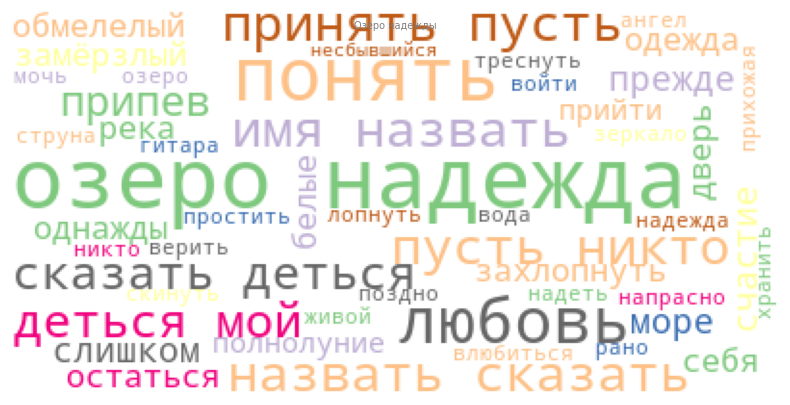

In [90]:
# TODO вынести в def
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.subplots_adjust(wspace=0.3, hspace=0.2)

i = 1

tokens = word_tokenize(df['song_text'][0])
text_raw = " ".join(tokens)
wordcloud = WordCloud(colormap='Accent', background_color='white', contour_width=10).generate(text_raw)
plt.tick_params(labelsize=10)
plt.imshow(wordcloud)
plt.axis("off")
plt.title(df['name'][0],fontdict={'fontsize':7,'color':'grey'},y=0.93)
plt.tick_params(labelsize=10)
i += 1

In [93]:
'''
frequencies, 
font_sizes, 
positions,
orientations, colors
'''
wordcloud.layout_

[(('озеро надежда', 1.0), 45, (79, 1), None, 'rgb(127, 201, 127)'),
 (('понять', 0.6666666666666666), 38, (26, 116), None, 'rgb(253, 192, 134)'),
 (('любовь', 0.5), 33, (148, 202), None, 'rgb(102, 102, 102)'),
 (('принять пусть', 0.3333333333333333),
  27,
  (2, 110),
  None,
  'rgb(191, 91, 23)'),
 (('пусть никто', 0.3333333333333333),
  27,
  (118, 198),
  None,
  'rgb(253, 192, 134)'),
 (('имя назвать', 0.3333333333333333),
  27,
  (57, 115),
  None,
  'rgb(190, 174, 212)'),
 (('назвать сказать', 0.3333333333333333),
  27,
  (184, 113),
  None,
  'rgb(253, 192, 134)'),
 (('сказать деться', 0.3333333333333333),
  25,
  (132, 1),
  None,
  'rgb(102, 102, 102)'),
 (('деться мой', 0.3333333333333333), 25, (151, 2), None, 'rgb(240, 2, 127)'),
 (('припев', 0.25), 22, (43, 26), None, 'rgb(127, 201, 127)'),
 (('слишком', 0.16666666666666666), 18, (173, 22), None, 'rgb(102, 102, 102)'),
 (('прежде', 0.16666666666666666), 18, (32, 311), None, 'rgb(190, 174, 212)'),
 (('море', 0.16666666666666

In [15]:
# Создание объекта TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Применение TF-IDF к текстовым данным
tfidf_matrix = tfidf_vectorizer.fit_transform(songs_list_norm)

# Получение списка ключевых слов и их значения TF-IDF для первого документа
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.toarray()[0]

# Сортировка слов по значениям TF-IDF
sorted_keywords = [word for _, word in sorted(zip(tfidf_scores, feature_names), reverse=True)]

print("Ключевые слова:", sorted_keywords)

Ключевые слова: ['озеро', 'надежда', 'понять', 'никто', 'любовь', 'пусть', 'назвать', 'имя', 'деться', 'принять', 'сказать', 'мой', 'припев', 'слишком', 'река', 'прийти', 'прежде', 'полнолуние', 'однажды', 'одежда', 'обмелелый', 'захлопнуть', 'замёрзлый', 'белые', 'счастие', 'себя', 'остаться', 'море', 'дверь', 'хранить', 'треснуть', 'струна', 'скинуть', 'рано', 'прихожая', 'поздно', 'несбывшийся', 'напрасно', 'надеть', 'мочь', 'лопнуть', 'зеркало', 'живой', 'гитара', 'войти', 'вода', 'влюбиться', 'ангел', 'верить', 'простить', 'ящик', 'юрьев', 'юность', 'южный', 'это', 'шальной', 'чудо', 'чувствовать', 'целый', 'царский', 'хотеть', 'ходить', 'уходить', 'успеть', 'уносить', 'унести', 'умолкать', 'умный', 'узнать', 'узкий', 'угнать', 'увидеться', 'ты', 'труд', 'тропа', 'трон', 'тридцать', 'трава', 'точно', 'тот', 'торговать', 'томиться', 'толкаться', 'течение', 'тень', 'темнота', 'тело', 'твой', 'таять', 'татьяна', 'также', 'тайна', 'сын', 'считать', 'суметь', 'судья', 'судьба', 'суд', 

In [16]:
feature_names

array(['адрес', 'ангел', 'анубис', 'багряный', 'бежать', 'белые', 'белый',
       'берег', 'бережно', 'битый', 'благодаря', 'блаженство',
       'боттичелли', 'бросить', 'былой', 'быстро', 'быть', 'вверх',
       'ведать', 'венок', 'верить', 'весь', 'ветер', 'вечность', 'взгляд',
       'видеть', 'вино', 'влюбиться', 'вновь', 'вода', 'войти', 'волков',
       'враг', 'врата', 'врач', 'время', 'вспомнить', 'встать', 'вчера',
       'гаснуть', 'герой', 'гитара', 'глаз', 'глубина', 'глядеть',
       'гнать', 'говорить', 'год', 'голова', 'гора', 'горсть',
       'грациозно', 'грех', 'губа', 'давность', 'два', 'дверь', 'девушка',
       'день', 'десять', 'деться', 'долго', 'должный', 'дом', 'дорога',
       'друг', 'душа', 'ещё', 'ждать', 'жест', 'жечь', 'живой', 'жизнь',
       'жить', 'заблудиться', 'забросить', 'закрывать', 'закрыть',
       'замёрзлый', 'запомнить', 'захлопнуть', 'звезда', 'зелёный',
       'зеркало', 'зима', 'знать', 'значит', 'золото', 'золотой', 'идти',
       'избра

In [17]:
tfidf_scores # TODO добавить в df колонку tf idf за файл общий

array([0.        , 0.0433582 , 0.        , 0.        , 0.        ,
       0.08671639, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.03498112, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.0433582 , 0.        , 0.0433582 ,
       0.0433582 , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.0433582 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.05807498, 0.        , 0.        , 0.        ,
       0.17343278, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.0433582 , 0.        , 0.        , 0.     

In [95]:

count_vectorizer = CountVectorizer()

bow = count_vectorizer.fit_transform(songs_list_norm)
bow.shape

(5, 328)

In [96]:
import operator
vocab_sorted = sorted(count_vectorizer.vocabulary_.items(), key=operator.itemgetter(0))
vocab_sorted

[('адрес', 0),
 ('ангел', 1),
 ('анубис', 2),
 ('багряный', 3),
 ('бежать', 4),
 ('белые', 5),
 ('белый', 6),
 ('берег', 7),
 ('бережно', 8),
 ('битый', 9),
 ('благодаря', 10),
 ('блаженство', 11),
 ('боттичелли', 12),
 ('бросить', 13),
 ('былой', 14),
 ('быстро', 15),
 ('быть', 16),
 ('вверх', 17),
 ('ведать', 18),
 ('венок', 19),
 ('верить', 20),
 ('весь', 21),
 ('ветер', 22),
 ('вечность', 23),
 ('взгляд', 24),
 ('видеть', 25),
 ('вино', 26),
 ('влюбиться', 27),
 ('вновь', 28),
 ('вода', 29),
 ('войти', 30),
 ('волков', 31),
 ('враг', 32),
 ('врата', 33),
 ('врач', 34),
 ('время', 35),
 ('вспомнить', 36),
 ('встать', 37),
 ('вчера', 38),
 ('гаснуть', 39),
 ('герой', 40),
 ('гитара', 41),
 ('глаз', 42),
 ('глубина', 43),
 ('глядеть', 44),
 ('гнать', 45),
 ('говорить', 46),
 ('год', 47),
 ('голова', 48),
 ('гора', 49),
 ('горсть', 50),
 ('грациозно', 51),
 ('грех', 52),
 ('губа', 53),
 ('давность', 54),
 ('два', 55),
 ('дверь', 56),
 ('девушка', 57),
 ('день', 58),
 ('десять', 59),
 (

# BERT

Цель этого задания-использовать предварительно обученную модель BERT для классификации тональности отзывов на фильмы.

-Скачайте датасет отзывов на фильмы. Датасет содержит текст отзыва и бинарную метку тональности (положительный/отрицательный).

-Используйте библиотеку HuggingFace transformers для загрузки предварительно обученной модели BERT и токенизатора.

-Подготовьте данные: используйте токенизатор BERT для преобразования текстовых данных в формат, который можно подать на вход модели BERT.

-Создайте классификатор нао снове BERT:это может быть модель BERT с одним линейным слоем для классификации на вершине.

-Обучите классификатор на данных обучения и оцените его производительность на данных для тестирования.


In [2]:
!pip install transformers 

Defaulting to user installation because normal site-packages is not writeable


hugging  face, russian - rubert, deeppavlov

In [8]:
import torch
import transformers as bert_trained
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

## Чтение данных

In [9]:
df = pd.read_csv(f"IMDB Dataset.csv")

In [10]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [11]:
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x=='positive' else 0)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [12]:
df.shape

(50000, 2)

In [13]:
df.describe(include="all")

,review,sentiment
count,50000,50000.000000
unique,49582,NaN
top,Loved today's show!!! It was a variety and not...,NaN
freq,5,NaN
mean,NaN,0.500000
std,NaN,0.500005
min,NaN,0.000000
25%,NaN,0.000000
50%,NaN,0.500000
75%,NaN,1.000000


Text(0.5, 0, 'sentiments')

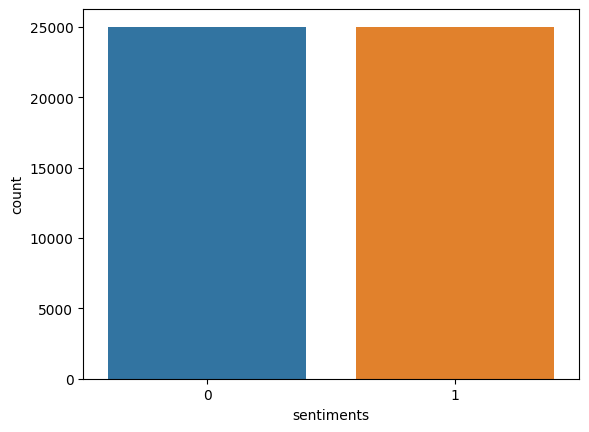

In [14]:
sns.countplot(x=df['sentiment'])
plt.xlabel('sentiments')

In [ ]:
# удалим знаки препинания и приведем к нижнему регистру
df['review'] = df['review'].apply(lambda x: re.sub(r'[^\w\s]', '', x.lower()))

df

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production br br the filmin...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically theres a family where a little boy j...,0
4,petter matteis love in the time of money is a ...,1
...,...,...
49995,i thought this movie did a down right good job...,1
49996,bad plot bad dialogue bad acting idiotic direc...,0
49997,i am a catholic taught in parochial elementary...,0
49998,im going to have to disagree with the previous...,0


In [17]:
# загрузка и удаление стоп-слов
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\V-C\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
stop_words.extend(['br']) # добавляет слово в словарь стоп-слов

In [19]:
df.shape

(50000, 2)

## Построить bert модель

In [20]:
from transformers import BertTokenizer



In [21]:
PRE_TRAINED_MODEL_NAME = r'bert-base-uncased'

In [22]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, do_lower_case=True)

In [ ]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f"Предложение: {sample_txt}")
print(f"Токены: {tokens}")
print(f"Идентификаторы токенов: {token_ids}")

max_len = max([len(sent) for sent in tokens])
print('Max length: ', max_len)

Предложение: When was I last outside? I am stuck at home for 2 weeks.
Токены: ['when', 'was', 'i', 'last', 'outside', '?', 'i', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Идентификаторы токенов: [2043, 2001, 1045, 2197, 2648, 1029, 1045, 2572, 5881, 2012, 2188, 2005, 1016, 3134, 1012]
Max length:  7


In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=10,
  truncation=True,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding='longest',
  return_attention_mask=True,
  return_tensors='pt',
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

10


tensor([ 101, 2043, 2001, 1045, 2197, 2648, 1029, 1045, 2572,  102])

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

10


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])
#[CLS] - непрерывное связывание, sentence-level classification, начало
# [SEP] - разделитель для предложения, конец

['[CLS]', 'when', 'was', 'i', 'last', 'outside', '?', 'i', 'am', '[SEP]']

## IMDB датасет

In [23]:
class IMDBDataset(Dataset):

  def __init__(self, reviews, sentiments, tokenizer, max_len):
    self.reviews = reviews
    self.sentiments = sentiments
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    sentiment = self.sentiments[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'sentiments': torch.tensor(sentiment, dtype=torch.long)
    }

In [24]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = IMDBDataset(
    reviews=df.review.to_numpy(),
    sentiments=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [25]:
short_df = df[:1000]

In [26]:
short_df.shape

(1000, 2)

In [27]:
RANDOM_SEED = 1234

df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [28]:
BATCH_SIZE = 16
MAX_LEN = 32

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [29]:
data = next(iter(train_data_loader))
data.keys()

## Классификация отзывов

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [ ]:
class IMDBClassifier(nn.Module):

  def __init__(self, n_classes):
    super(IMDBClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
device = torch.device( 'cuda' if torch.cuda.is_available() else 'cpu' )

In [ ]:
model = IMDBClassifier(len(df['sentiment'].unique()))
model = model.to(device)

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape)
print(attention_mask.shape)

In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

In [ ]:
EPOCHS = 4

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    sentiments = d["sentiments"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, sentiments)

    correct_predictions += torch.sum(preds == sentiments)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      sentiments = d["sentiments"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, sentiments)

      correct_predictions += torch.sum(preds == sentiments)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

train_a = []
train_l = []
val_a = []
val_l = []
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  train_a.append(train_acc)
  train_l.append(train_loss)
  val_a.append(val_acc)
  val_l.append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

In [ ]:
plt.plot(train_a, label='train accuracy')
plt.plot(val_a, label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['sentiments'].shape)

In [42]:
short_df = df[:300]

In [38]:
def clean_eng(x):
    return ' '.join([word for word in word_tokenize(x) if word not in stop_words])

In [44]:
short_df

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production br br the filmin...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically theres a family where a little boy j...,0
4,petter matteis love in the time of money is a ...,1
...,...,...
295,despite a totally misleading advertising campa...,0
296,this movie sucks ass something about a heatwav...,0
297,i was looking forward to the guardian but when...,1
298,going into see seven pounds i wasnt clearly su...,1


In [45]:
short_df['review'] = short_df['review'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in stop_words]))

C:\Users\V-C\AppData\Local\Temp\ipykernel_10100\1966154660.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_df['review'] = short_df['review'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in stop_words]))


In [46]:
short_df

,review,sentiment
0,one reviewers mentioned watching 1 oz episode ...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically theres family little boy jake thinks...,0
4,petter matteis love time money visually stunni...,1
...,...,...
295,despite totally misleading advertising campaig...,0
296,movie sucks ass something heatwave european co...,0
297,looking forward guardian walked theater wasnt ...,1
298,going see seven pounds wasnt clearly sure thin...,1


In [47]:
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Загрузка предобученной модели/токенизатора
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

C:\Users\V-C\AppData\Roaming\Python\Python38\site-packages\huggingface_hub\file_download.py:137: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\V-C\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [49]:
short_df['review'].value_counts()

one reviewers mentioned watching 1 oz episode youll hooked right exactly happened mebr first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use wordbr called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home manyaryans muslims gangstas latinos christians italians irish moreso scuffles death stares dodgy dealings shady agreements never far awaybr would say main appeal show due fact goes shows wouldnt dare forget pretty pictures painted mainstream audiences forget charm forget romanceoz doesnt mess around first episode ever saw struck nasty surreal couldnt say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards wholl sold nickel inmates wholl kill order get away well mannered middle c

In [50]:
tokenized_df = short_df['review'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True,truncation=True)))

In [51]:
tokenized_df

0      [101, 2028, 15814, 3855, 3666, 1015, 11472, 27...
1      [101, 6919, 2210, 2537, 7467, 6028, 14477, 475...
2      [101, 2245, 6919, 2126, 5247, 2051, 2980, 2621...
3      [101, 10468, 2045, 2015, 2155, 2210, 2879, 518...
4      [101, 9004, 3334, 4717, 17580, 2293, 2051, 276...
                             ...                        
295    [101, 2750, 6135, 22369, 6475, 3049, 17312, 43...
296    [101, 3185, 19237, 4632, 2242, 3684, 16535, 26...
297    [101, 2559, 2830, 6697, 2939, 4258, 2347, 2102...
298    [101, 2183, 2156, 2698, 7038, 2347, 2102, 4415...
299    [101, 2387, 3428, 5192, 5917, 3540, 2143, 2782...
Name: review, Length: 300, dtype: object

In [52]:
# Find the maximum length
max_len = max([len(sent) for sent in tokenized_df])
print('Max length: ', max_len)

Max length:  512


In [53]:
short_df.dtypes

review       object
sentiment    object
dtype: object

In [54]:
short_df['tokenized_review'] = tokenized_df

C:\Users\V-C\AppData\Local\Temp\ipykernel_10100\220809615.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_df['tokenized_review'] = tokenized_df


In [56]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val =\
    train_test_split(short_df['tokenized_review'], short_df['sentiment'], test_size=0.1, random_state=2020)

In [ ]:
# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )

        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [ ]:
# Specify `MAX_LEN`
MAX_LEN = 64

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)